# Spaceship

## Task description

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## File and Data Field Descriptions


### **train.csv**  - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.

Your task is to predict the value of Transported for the passengers in this set.

### **sample_submission.csv** - A submission file in the correct format.

PassengerId - Id for each passenger in the test set.

Transported - The target. For each passenger, predict either True or False.

Here are the first 5 rows of the data:

In [31]:
# Load data
import pandas as pd

train_unprocessed = pd.read_csv('datasets/train.csv')
test_unprocessed = pd.read_csv('datasets/test.csv')

train_size = len(train_unprocessed)

data = pd.concat([train_unprocessed, test_unprocessed]).reset_index()

data.head()

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         12970 non-null  int64  
 1   PassengerId   12970 non-null  object 
 2   HomePlanet    12682 non-null  object 
 3   CryoSleep     12660 non-null  object 
 4   Cabin         12671 non-null  object 
 5   Destination   12696 non-null  object 
 6   Age           12700 non-null  float64
 7   VIP           12674 non-null  object 
 8   RoomService   12707 non-null  float64
 9   FoodCourt     12681 non-null  float64
 10  ShoppingMall  12664 non-null  float64
 11  Spa           12686 non-null  float64
 12  VRDeck        12702 non-null  float64
 13  Name          12676 non-null  object 
 14  Transported   8693 non-null   object 
dtypes: float64(6), int64(1), object(8)
memory usage: 1.5+ MB


**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

The number of a passenger within their group is arbitrary, so we don't need it. However, group numbers may be important, so we'll create a new feature "Group".

In [33]:
data['Group'] = data['PassengerId'].str[:4]
print(data['Group'].info())
print(data['Group'].describe())
print('Unique Values:')
print(data['Group'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: Group
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique     9280
top        6499
freq          8
Name: Group, dtype: object
Unique Values:
['0001' '0002' '0003' ... '9271' '9273' '9277']


As we can see above, there are no missing values in Group.

Some other columns, though, have missing values. Let's explore if there are some patterns in missing data:

index              0
PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
Group              0
dtype: int64


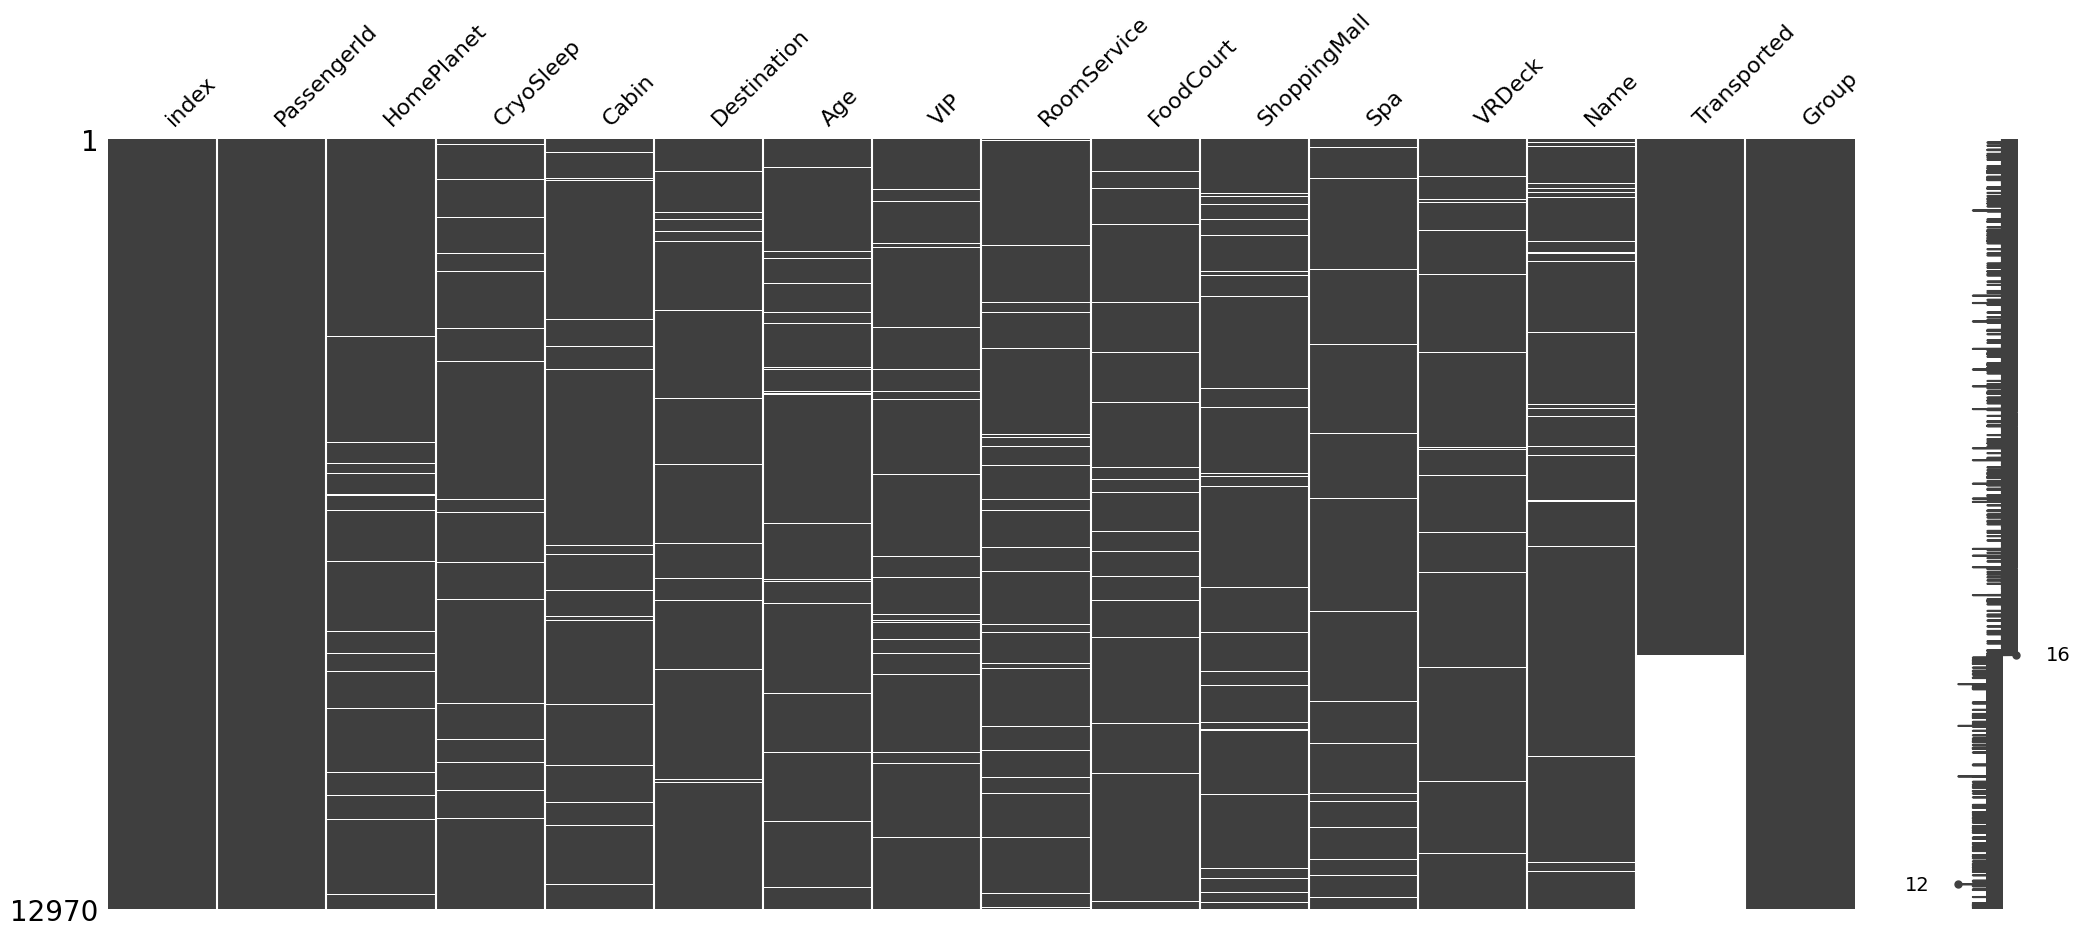

In [34]:
import missingno as msno
import matplotlib.pyplot as plt

# Print number of missing values in banking
print(data.isna().sum())

# Visualize missingness matrix
msno.matrix(data)
plt.show()

It seems that values are Missing At Random (Transported column is our target, it is missing in test data). We'll fill the missing values column by column, based on the description of the dataset.

**Name** - The first and last names of the passenger.

We don't need the first names, so we'll strip them. 
Additionally, we may assume that passengers with the same last names in different Groups are not relatives. To avoid treating them as relatives, we will append Group names to all last names:


In [35]:
### !!!! FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

data.Name = data.Name.str.split(' ', 1).str[1]
data.Name = data.Name + data.Group

We'll fill the missing values for Names based on the most common surname in their Group.
If a passenger is alone in their group, we'll name them by the name of their Group:

In [36]:
# Iterate through all the rows with missing data
for index in data[data['Name'].isna()].index:
    # Fill the missing values for lonely passengers:
    if len(data[data['Group'] == data.loc[index, 'Group']]) == 1:
        data.loc[index, "Name"] = data.loc[index, 'Group']
    # Fill the missing values for non-lonely passengers:
    else:
        data.loc[index, "Name"] = data[(data['Group'] == data.loc[index, 'Group']) & \
                (data['Name'].isna() == False)]['Name'].mode()[0]

As you can see below, now Name doesn't have missing values:

In [37]:
print(data['Name'].info())
print(data['Name'].describe())
print('Unique Values:')
print(data['Name'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count              12970
unique              9691
top       Barnolderg6499
freq                   8
Name: Name, dtype: object
Unique Values:
['Ofracculy0001' 'Vines0002' 'Susent0003' ... 'Pore9271' 'Conale9273'
 'Leonzaley9277']


**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**Destination** - The planet the passenger will be debarking to.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

It makes sense that these three features depend on Group and Name, so we'll fill the missing values accordingly. For lonely passengers, we'll fill these columns with the most common values.

We have two unique cases where the whole group has missing values. We'll fill them first:

In [44]:
data.loc[6917:6918, 'HomePlanet'] = data['HomePlanet'].mode()[0]
data.loc[5778:5779, 'VIP'] = data['VIP'].mode()[0]
data.loc[12941:12942, 'Cabin'] = data['Cabin'].mode()[0]

In [46]:
# List of columns with missing values
columns_to_fill = ['HomePlanet', 'Destination', 'VIP', 'Cabin']

# Iterate through all columns with missing values
for column in columns_to_fill:
    # Iterate through all the rows with missing data
    for index in data[data[column].isna()].index:
        # Fill the missing values for passengers alone in their group:
        if len(data[data['Group'] == data.loc[index, 'Group']]) == 1:
            data.loc[index, column] = data[column].mode()[0]
         # Fill the missing values for passengers with an unique last name:
        elif len(data[data['Name'] == data.loc[index, 'Name']]) == 1:
            data.loc[index, column] = data[(data['Group'] == data.loc[index, 'Group']) & \
                (data[column].isna() == False)][column].mode()[0]
        # Fill the missing values for non-lonely passengers:
        else:
            data.loc[index, column] = data[(data['Group'] == data.loc[index, 'Group']) & \
                            (data['Name'] == data.loc[index, 'Name']) & \
                            (data[column].isna() == False)][column].mode()[0]

Let's check the filled columns:


In [47]:
for column in columns_to_fill:
    print(data[column].info())
    print(data[column].describe())
    print('Unique Values:')
    print(data[column].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: HomePlanet
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique        3
top       Earth
freq       7071
Name: HomePlanet, dtype: object
Unique Values:
['Europa' 'Earth' 'Mars']
<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: Destination
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count           12970
unique              3
top       TRAPPIST-1e
freq             9106
Name: Destination, dtype: object
Unique Values:
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']
<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: VIP
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique        2
top       Fal

Everything is good now, but we want to extract the useful data from Cabin.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Let's extract Deck and Side, and drop Cabin:

In [50]:
data['Deck'] = data.Cabin.str[0]
data['Side'] = data.Cabin.str[-1]

data = data.drop('Cabin', axis=1)

for column in ['Deck', 'Side']:
    print(data[column].info())
    print(data[column].describe())
    print('Unique Values:')
    print(data[column].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: Deck
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique        8
top           F
freq       4268
Name: Deck, dtype: object
Unique Values:
['B' 'F' 'A' 'G' 'E' 'D' 'C' 'T']
<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: Side
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique        2
top           P
freq       6516
Name: Side, dtype: object
Unique Values:
['P' 'S']


Seems great. Let's move on.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

I assume that CryoSleep may be dependend on HomePlanet and Destination. Let's check:

In [68]:
pd.pivot_table(data, values='CryoSleep', index=['HomePlanet'], columns=["Destination"])

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,0.317317,0.508364,0.263049
Europa,0.514111,0.551724,0.401938
Mars,0.419795,0.227273,0.396701


Indeed, there is some dependency. Let's fill the missing values in CryoSleep based on these two columns:

In [70]:
# Iterate through all the rows with missing data
for index in data[data['CryoSleep'].isna()].index:
    # Fill the missing values:
    data.loc[index, "CryoSleep"] = data[(data['HomePlanet'] == data.loc[index, 'HomePlanet']) & \
                                        (data['Destination'] == data.loc[index, 'Destination']) & \
                            (data['CryoSleep'].isna() == False)]['CryoSleep'].mode()[0]
    
print(data['CryoSleep'].info())
print(data['CryoSleep'].describe())
print('Unique Values:')
print(data['CryoSleep'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: CryoSleep
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique        2
top       False
freq       8333
Name: CryoSleep, dtype: object
Unique Values:
[False True]


**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Almost all passengers with CryoSleep == True do not spend money on servises. Here is the 99th quantiles:

In [76]:
print(data[data['CryoSleep'] == True].quantile(0.99))

index           8570.64
Age               65.00
RoomService        0.00
FoodCourt          0.00
ShoppingMall       0.00
Spa                0.00
VRDeck             0.00
Name: 0.99, dtype: float64


Therefore, we can fill missing values with 0's for such passengers:

In [83]:
data[data['CryoSleep'] == True] = data[data['CryoSleep'] == True].fillna(0)

How about prices for services of VIP vs not VIP?

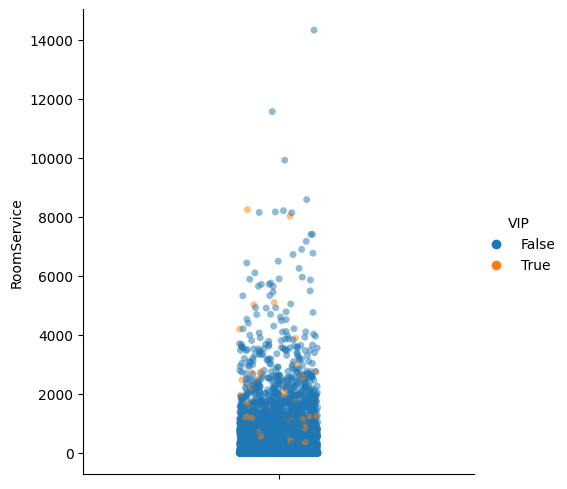

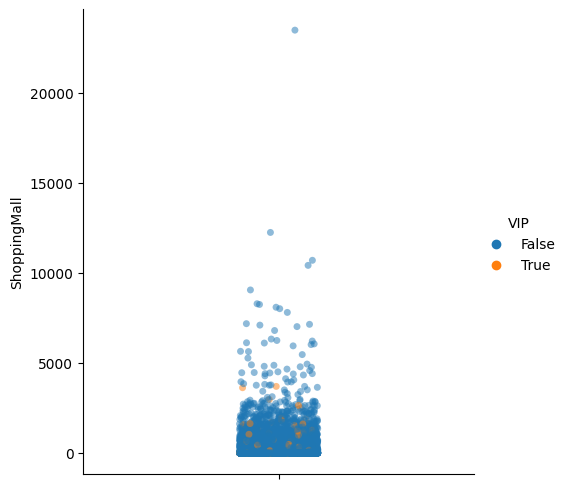

In [88]:
import seaborn as sns

sns.catplot(data=data, y='RoomService', hue='VIP', alpha = 0.5)
sns.catplot(data=data, y='ShoppingMall', hue='VIP', alpha = 0.5)

Seems that VIP status does not affect spending much. 

For now, let's fill the missing values in these columns with average values for non-sleeping passengers:

In [90]:
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for column in spending_columns:
    data.loc[data[column].isna(), column] = data.loc[data['CryoSleep'] == False, column].mean()

for column in spending_columns:
    print(data[column].info())
    print(data[column].describe())
    print('Unique Values:')
    print(data[column].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: RoomService
Non-Null Count  Dtype  
--------------  -----  
12970 non-null  float64
dtypes: float64(1)
memory usage: 101.5 KB
None
count    12970.000000
mean       222.901265
std        641.427132
min          0.000000
25%          0.000000
50%          0.000000
75%         62.000000
max      14327.000000
Name: RoomService, dtype: float64
Unique Values:
[   0.  109.   43. ... 1278. 2835.  652.]
<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: FoodCourt
Non-Null Count  Dtype  
--------------  -----  
12970 non-null  float64
dtypes: float64(1)
memory usage: 101.5 KB
None
count    12970.000000
mean       451.505806
std       1567.434780
min          0.000000
25%          0.000000
50%          0.000000
75%         94.750000
max      29813.000000
Name: FoodCourt, dtype: float64
Unique Values:
[   0.    9. 3576. ...  873. 4813.  601.]
<class 'pandas.core.series.Series'

Now we don't have missing values there, as well as negative values.